<a id='section_id3'></a>
# Kennzahl Wirtschaftlichkeit

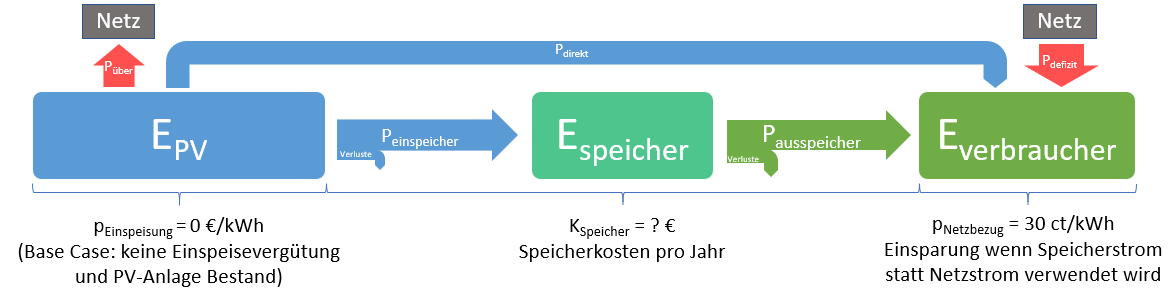



\begin{eqnarray}
K_{Einsparung}=E_{ausspeicher} \cdot p_{Netzbezug} - E_{einspeicher} \cdot p_{Einspeisung}-K_{Speicher}
\end{eqnarray}

\begin{eqnarray}
K_{Einsparung}=E_{H2,eingespeichert} \cdot p_{H2} - E_{einspeicher} \cdot p_{Einspeisung}-K_{Speicher}
\end{eqnarray}

\
Verwendete Skripte:\
[Parameter Base Case](parameter_base_case.py)\
[Hilfsfunktionen](own_utility_functions.py)\
[Visualisierung](visualisation.py)\
[Speicher](speicher.py)\
[Wirtschaftlichkeit](wirtschaftlichkeit.py)



## Initialisierung

In [1]:
from parameter_base_case import *
Lastprofilnr=31


Nr=str(Lastprofilnr)
with open(directory_data+'Lastprofil_'+Nr+'.npy', 'rb') as f:
    [P_verbraucher, P_pv, P_dif, P_def, P_ueber] = np.load(f)

E_verbraucher = jahresenergie_kWh(P_verbraucher)
E_def = jahresenergie_kWh(P_def)
E_ueber = jahresenergie_kWh(P_ueber)

#Zeitausschnitte für Visualisierung
days = timeline.minute_period('2019-09-22','2019-09-25')
year = timeline.minute_period('2019-01-01','2019-12-31')
year_dayres = timeline.day_period('2019-01-01','2019-12-31')

##Batteriesystemdaten laden
with open(directory_data+'batterie_kapazitaet_'+file_extension+Nr+'.npy', 'rb') as f:
    [E_bat_max_array, E_jahr_bat] = np.load(f)
##Wasserstoffsystemdaten laden
with open(directory_data+'RFC_speicherleistung_'+file_extension+Nr+'.npy', 'rb') as f:
    [P_RFC_charge_max_array, E_h2_netto] = np.load(f)
##Wasserstoffsystem+Sektorkopplung Daten laden
with open(directory_data+'RFC_sektorkopplung_speicherleistung_'+file_extension+Nr+'.npy', 'rb') as f:
    [P_RFC_charge_max_array_sektor, E_h2_elektro_netto, E_h2_waerme_netto] = np.load(f)
##Wasserstoffverkauf Daten laden
with open(directory_data+'P2G_speicherleistung_'+file_extension+Nr+'.npy', 'rb') as f:
    [P_P2G_charge_max_array, E_h2] = np.load(f)



# -------------------------------------------------------------------------------------------------------------


## Wasserstoffrückverstromung ohne Sektorkopplung

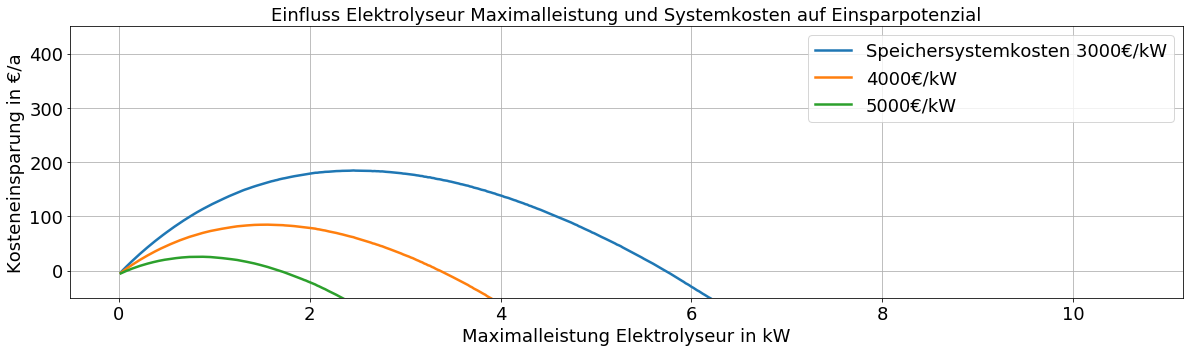

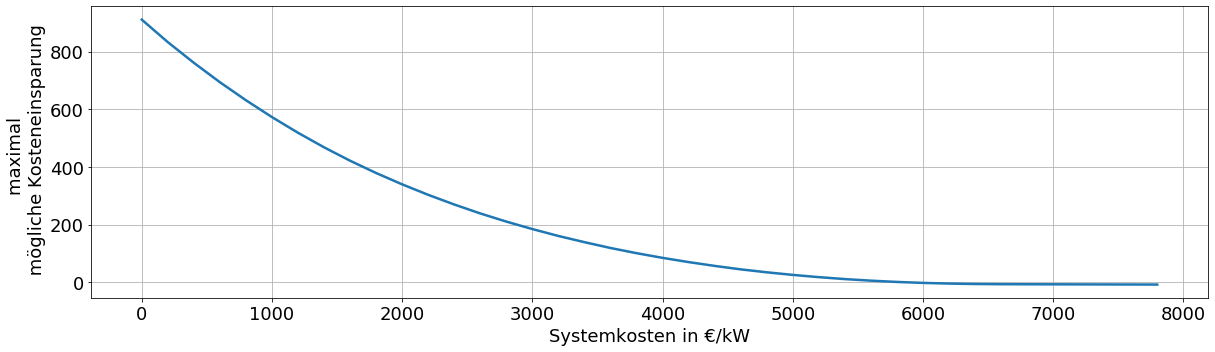

In [2]:
##Wasserstoffrückverstromung ohne Sektorkopplung
##Kostenersparnis bei vollständiger Rückumwandlung mit Brennstoffzelle
elektrolysekostenfaktor = [150, 200, 250]
#elektrolysekostenfaktor = np.arange(100,400,10)
first=0
for value in elektrolysekostenfaktor:
    Kosteneinsparung=E_h2_netto*c_netz-P_RFC_charge_max_array*value/1000-c_einspeisung*E_h2_netto/eff_elektrolyse/eff_brennstoffzelle
    if first==0:
        ax=vis.plot(P_RFC_charge_max_array/1000, Kosteneinsparung,
        'Maximalleistung Elektrolyseur in kW', 'Kosteneinsparung in €/a', \
        'Einfluss Elektrolyseur Maximalleistung und Systemkosten auf Einsparpotenzial')
        legend = ['Speichersystemkosten '+ "%4.0f" % (value*20) +'€/kW']
        first=1
    else:
        legend.append("%4.0f" % (value*20) +'€/kW')
        vis.addtoplot(ax,P_RFC_charge_max_array/1000, Kosteneinsparung, legend,'best')
        
#plt.xlim(0,5)
plt.ylim(-50,450)
vis.save_to_tex('diagramm_wirtschaftlichkeit_elektrolyseurleistung_RFC'+'_'+file_extension,ax)


elektrolysekostenfaktor = np.arange(0,400,10)
Kostenoptimum_array=[]
for value in elektrolysekostenfaktor:
    Kosteneinsparung=E_h2_netto*c_netz-P_RFC_charge_max_array*value/1000-c_einspeisung*E_h2_netto/eff_elektrolyse/eff_brennstoffzelle
    Kostenoptimum_array.append(np.max(Kosteneinsparung))
vis.plot(elektrolysekostenfaktor*20,Kostenoptimum_array,'Systemkosten in €/kW', 'maximal \n mögliche Kosteneinsparung')
vis.save_to_tex('diagramm_wirtschaftlichkeitvssystemkosten_RFC'+'_'+file_extension,ax)


# ----------------------------------------------------------------------------------------------------------------

## Wasserstoffrückverstromung mit Sektorkopplung

Annahme die Wärmeenergie kann vollständig genutzt werden --> für genauere Aussage über Effekt von Sektorkopplung muss der Wärmeenergiebedarf modelliert werden --> hier Optimalfall alle anfallende Abwärme wird genutzt daher ist die tatsächliche Wirtschaftlichkeit deutlich geringer

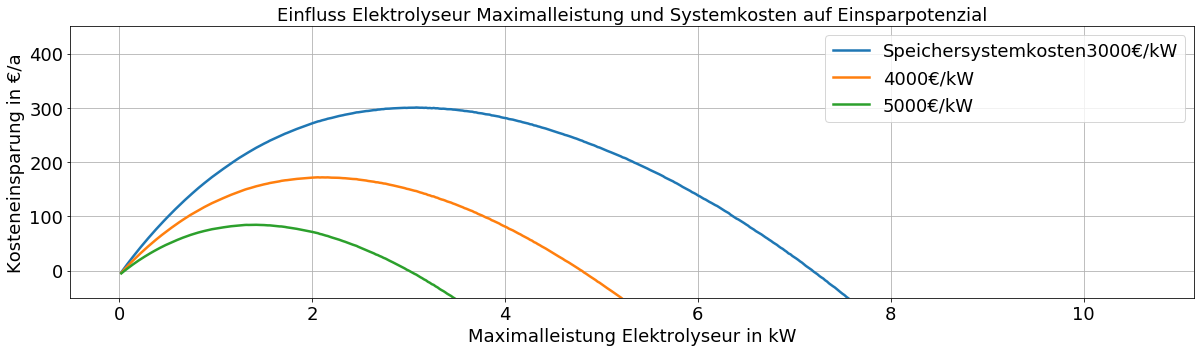

In [3]:
##Wasseerstoffspeicher mit Sektorkopplung
#ax=vis.plot(P_RFC_charge_max_array_sektor, E_h2_elektro_netto,'Maxleistung Elektrolyseur in W','zusätzlich verfügbare \n Energie in kWh','Wasserstoffrückverstromung mit Sektorkopplung')
#vis.addtoplot(ax,P_RFC_charge_max_array_sektor, E_h2_waerme_netto,['Elektrische Energie','Wärme Energie'],'best')

##Kostenersparnis bei Wärmeenergievergütung 6ct/kWh
elektrolysekostenfaktor = [150, 200, 250]
length=int(np.size(P_RFC_charge_max_array)/1.5)
first=0
for value in elektrolysekostenfaktor:
    Kosteneinsparung=E_h2_elektro_netto*c_netz-P_RFC_charge_max_array*value/1000+E_h2_waerme_netto*0.06-c_einspeisung*E_h2_elektro_netto/eff_elektrolyse/eff_brennstoffzelle
    if first==0:
        ax=vis.plot(P_RFC_charge_max_array/1000, Kosteneinsparung,
        'Maximalleistung Elektrolyseur in kW', 'Kosteneinsparung in €/a', \
        'Einfluss Elektrolyseur Maximalleistung und Systemkosten auf Einsparpotenzial')
        legend = ['Speichersystemkosten'+ "%4.0f" % (value*20) +'€/kW']
        first=1
    else:
        legend.append("%4.0f" % (value*20) +'€/kW')
        vis.addtoplot(ax,P_RFC_charge_max_array[0:length]/1000, Kosteneinsparung[0:length], legend,'best')
plt.ylim(-50, 450); 
#plt.xlim(0,5)
vis.save_to_tex('diagramm_wirtschaftlichkeit_elektrolyseurleistung_RFC_sektor'+'_'+file_extension,ax)

##Vergleich mit Funktion aus wirtschaftlichkeit.py
#elektrolysekostenfaktor_new=[150/1000, 200/1000, 250/1000] #in €/W
#ax,data=wirtschaftlichkeit.RFC_mit_sektorkopplung(E_h2_elektro_netto,E_h2_waerme_netto,eff_elektrolyse,eff_brennstoffzelle,P_RFC_charge_max_array,elektrolysekostenfaktor_new,c_netz,c_einspeisung)

# ------------------------------------------------------------------------------------------------------------

## Batteriespeicher

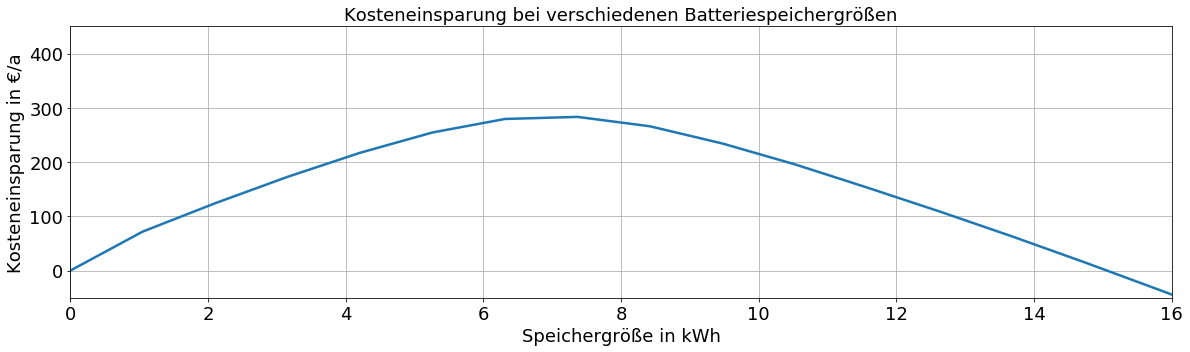

In [4]:
ax=vis.plot(E_bat_max_array,E_jahr_bat*c_netz-K_system_batterie*E_bat_max_array-c_einspeisung*E_jahr_bat/eff_bat,\
            'Speichergröße in kWh','Kosteneinsparung in €/a','Kosteneinsparung bei verschiedenen Batteriespeichergrößen')

plt.ylim(-50, 450);
plt.xlim(0,16)
vis.save_to_tex('diagramm_wirtschaftlichkeit_batteriekapazitaet'+'_'+file_extension,ax)


## Wasserstoffverkauf

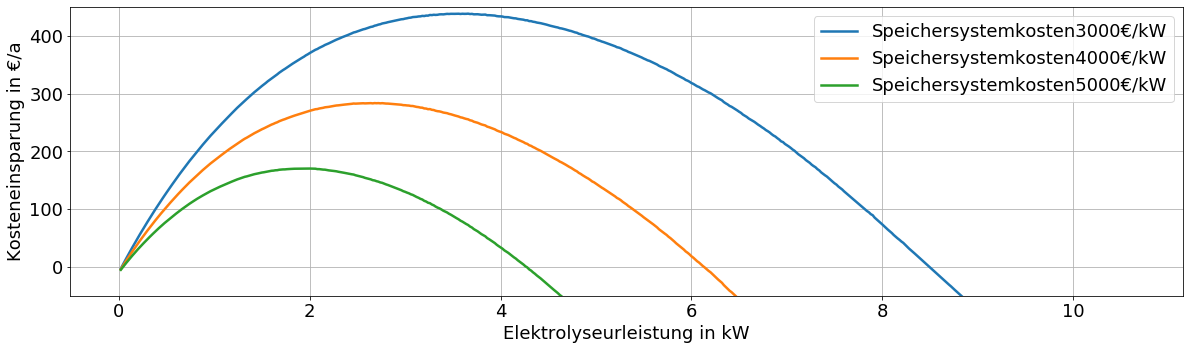

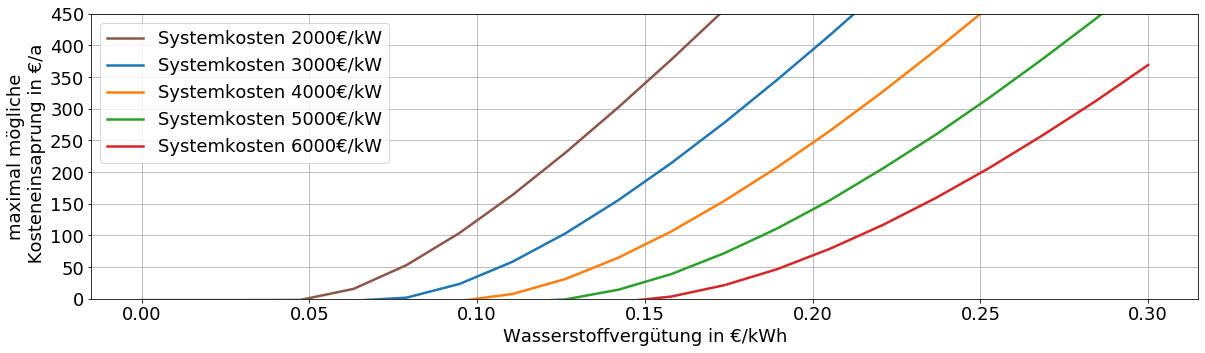

In [5]:
#vis.plot(P_P2G_charge_max_array, E_h2,'','','')
#Wasserstoffrückverstromung ohne Sektorkopplung
systemkosten = 150
#autarkiegrad = (E_verbraucher-jahresenergie_kWh(P_def)+E_h2_netto)/E_verbraucher*100
Kosteneinsparung=E_h2*wasserstoffverguetung-P_P2G_charge_max_array*systemkosten/1000-c_einspeisung*E_h2/eff_elektrolyse
legend = ['Speichersystemkosten'+ "%4.0f" % (systemkosten*20) +'€/kW']
ax=vis.plot(P_P2G_charge_max_array/1000, Kosteneinsparung,'Elektrolyseurleistung in kW', 'Kosteneinsparung in €/a','')
systemkosten = 200
Kosteneinsparung=E_h2*wasserstoffverguetung-P_P2G_charge_max_array*systemkosten/1000-c_einspeisung*E_h2/eff_elektrolyse
legend.append('Speichersystemkosten'+ "%4.0f" % (systemkosten*20) +'€/kW')
vis.addtoplot(ax,P_P2G_charge_max_array/1000, Kosteneinsparung, legend,'best')
systemkosten = 250
Kosteneinsparung=E_h2*wasserstoffverguetung-P_P2G_charge_max_array*systemkosten/1000-c_einspeisung*E_h2/eff_elektrolyse
legend.append('Speichersystemkosten'+ "%4.0f" % (systemkosten*20) +'€/kW')
vis.addtoplot(ax,P_P2G_charge_max_array/1000, Kosteneinsparung, legend,'best')
#systemkosten = 400
#Kosteneinsparung=E_h2*wasserstoffverguetung-P_P2G_charge_max_array*systemkosten/1000-c_einspeisung*E_h2/eff_elektrolyse
#legend.append('Elektrolyseur'+"%4.0f" % systemkosten +'€/kW')
#vis.addtoplot(ax,P_P2G_charge_max_array/1000, Kosteneinsparung, legend,'best')
plt.ylim(-50, 450);
#plt.xlim(0, 5)
vis.save_to_tex('diagramm_wirtschaftlichkeit_elektrolyseurleistung_P2G',ax)


Wasserstoffpreis_array = np.linspace(0, 0.3, 20)
first=1
systemkosten_array = np.arange(100, 301, 50)
for val in systemkosten_array:
    Kostenoptimum_array=[]
    for value in Wasserstoffpreis_array:
        Kosteneinsparung=E_h2*value-P_P2G_charge_max_array*val/1000-c_einspeisung*E_h2/eff_elektrolyse
        Kostenoptimum_array.append(np.max(Kosteneinsparung))
    if first:
        ax=vis.plot(Wasserstoffpreis_array,Kostenoptimum_array,'Wasserstoffvergütung in €/kWh',\
                    'maximal mögliche\n Kosteneinsaprung in €/a','',5)
        first=0
        legend=['Systemkosten '+"%4.0f" % (val*20) +'€/kW']
    else:
        legend.append('Systemkosten '+"%4.0f" % (val*20) +'€/kW')
        vis.addtoplot(ax,Wasserstoffpreis_array,Kostenoptimum_array,legend,'best')
plt.ylim(0, 450);
vis.save_to_tex('diagramm_wasserstoffverkauf_verguetungseinfluss'+'_'+file_extension,ax)



# ------------------------------------------------------------------------------------------------------------


## Vergleich

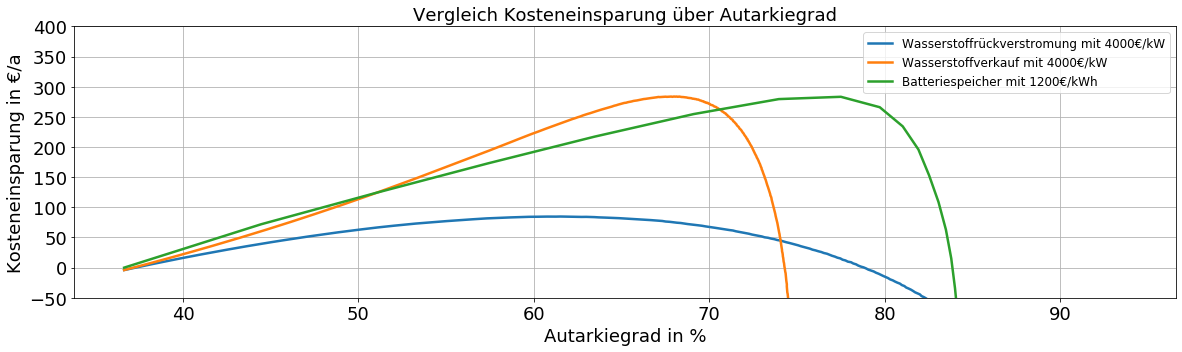

In [6]:
#Wasserstoffrückverstromung ohne Sektorkopplung
systemkosten = 200
autarkiegrad = (E_verbraucher-jahresenergie_kWh(P_def)+E_h2_netto)/E_verbraucher*100
Kosteneinsparung=E_h2_netto*c_netz-P_RFC_charge_max_array*systemkosten/1000-c_einspeisung*E_h2_netto/eff_elektrolyse/eff_brennstoffzelle
legend = ['Wasserstoffrückverstromung mit '+"%4.0f" % (systemkosten*20) +'€/kW']
ax=vis.plot(autarkiegrad, Kosteneinsparung,'Autarkiegrad in %', 'Kosteneinsparung in €/a','Vergleich Kosteneinsparung über Autarkiegrad')
#systemkosten = 200
#Kosteneinsparung=E_h2_netto*c_netz-Kosten_elektrolyse(P_RFC_charge_max_array,systemkosten)-c_einspeisung*E_h2_netto/eff_elektrolyse/eff_brennstoffzelle
#legend.append('Wasserstoffrückverstromung ohne Sektorkopplung'+"%4.0f" % systemkosten +'€/kW/Jahr')
#vis.addtoplot(ax,autarkiegrad, Kosteneinsparung, legend,'best')
#systemkosten = 250
#Kosteneinsparung=E_h2_netto*c_netz-Kosten_elektrolyse(P_RFC_charge_max_array,systemkosten)-c_einspeisung*E_h2_netto/eff_elektrolyse/eff_brennstoffzelle
#legend.append('Wasserstoffrückverstromung ohne Sektorkopplung'+"%4.0f" % systemkosten +'€/kW/Jahr')
#vis.addtoplot(ax,autarkiegrad, Kosteneinsparung, legend,'best')

'''
#Wasserstoffrückverstromung mit Sektorkopplung
systemkosten = 200
legend.append('Wasserstoffrückverstromung mit Sektorkopplung '+"%4.0f" % (systemkosten*20) +'€/kW')
Kosteneinsparung=E_h2_elektro_netto*c_netz-P_RFC_charge_max_array*systemkosten/1000\
    +E_h2_waerme_netto*kosten_waermeenergie-c_einspeisung*E_h2_elektro_netto/eff_elektrolyse/eff_brennstoffzelle
autarkiegrad = (E_verbraucher-jahresenergie_kWh(P_def)+E_h2_elektro_netto)/E_verbraucher*100
vis.addtoplot(ax,autarkiegrad, Kosteneinsparung, legend,'best')
'''

#Wasserstoffverkauf
autarkie_P2G=(E_verbraucher-jahresenergie_kWh(P_def)+E_h2/eff_elektrolyse)/(E_verbraucher+E_h2/eff_elektrolyse)*100
Kosteneinsparung_P2G=E_h2*wasserstoffverguetung-P_P2G_charge_max_array*200/1000-c_einspeisung*E_h2/eff_elektrolyse
vis.addtoplot(ax,autarkie_P2G,Kosteneinsparung_P2G)
legend.append('Wasserstoffverkauf mit 4000€/kW')

#Batteriespeicher
autarkiegrad = (E_verbraucher-jahresenergie_kWh(P_def)+E_jahr_bat)/E_verbraucher*100
legend.append('Batteriespeicher mit 1200€/kWh')
vis.addtoplot(ax,autarkiegrad, E_jahr_bat*c_netz-E_bat_max_array*K_system_batterie-c_einspeisung*E_jahr_bat/eff_bat,legend,'upper left')

plt.legend(legend,fontsize=12)
plt.ylim(-50, 400);
#plt.xlim(30, 65)

vis.save_to_tex('diagramm_wirtschaftlichkeit_vs_autarkie_vergleich'+'_'+file_extension,ax)

